<a href="https://colab.research.google.com/github/fbeilstein/machine_learning/blob/master/lecture_10_manifold_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Manifold learning—a class of unsupervised estimators that seeks to describe datasets as low-dimensional manifolds embedded in high-dimensional spaces.



*   multidimensional scaling (MDS)
*   locally linear embedding (LLE)
*   isometric mapping (Isomap)



In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

#Manifold Learning: “HELLO”

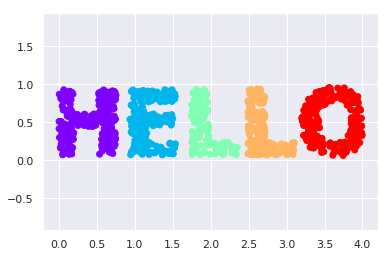

In [2]:
# generate data for further usage

def make_hello(N=1000, rseed=42):
  # Make a plot with "HELLO" text; save as PNG
  fig, ax = plt.subplots(figsize=(4, 1))
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
  ax.axis('off')
  ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
  fig.savefig('hello.png')
  plt.close(fig)
  # Open this PNG and draw random points from it
  from matplotlib.image import imread
  data = imread('hello.png')[::-1, :, 0].T
  rng = np.random.RandomState(rseed)
  X = rng.rand(4 * N, 2)
  i, j = (X * data.shape).astype(int).T
  mask = (data[i, j] < 1)
  X = X[mask]
  X[:, 0] *= (data.shape[0] / data.shape[1])
  X = X[:N]
  return X[np.argsort(X[:, 0])]

X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

#Multidimensional Scaling (MDS)

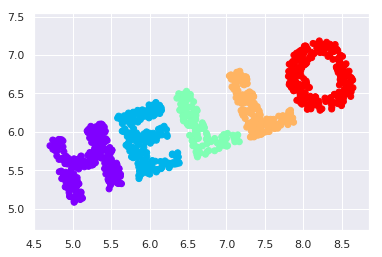

In [3]:
def rotate(X, angle):
  theta = np.deg2rad(angle)
  R = [[np.cos(theta), np.sin(theta)],
       [-np.sin(theta), np.cos(theta)]]
  return np.dot(X, R)

X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

In [4]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape
# matrix of pairwise distances between points

(1000, 1000)

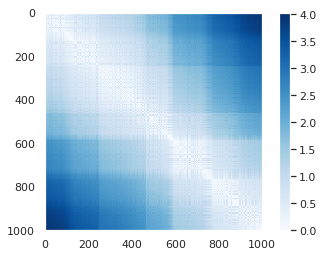

In [5]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

In [6]:
# rotated mage gives rise to similar matrix
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

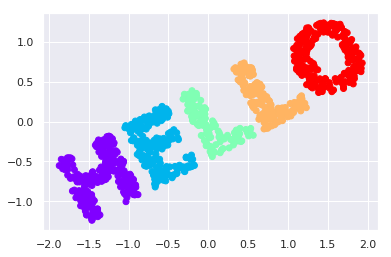

In [7]:
# recover D-dim representation by given distance matrix
from sklearn.manifold import MDS

model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

#MDS as Manifold Learning